# Load necessary modules

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import mxnet as mx
import numpy as np
import pandas as pd

import logging
logging.getLogger().setLevel(logging.DEBUG)

# Load Data
1. Read the clean expression data and metadata file
2. Split the expression data columns from metadata columns and map classes (learning type) to number codes

In [3]:
dat = pd.read_csv('data/mice_proteins_cleaned.csv',index_col=0)
dat = dat.fillna(0)
dat.shape

(1080, 83)

In [4]:
full_data_matrix = dat.iloc[:,:77].values

# Define the Neural Network

The input data are the expression values for all 77 proteins:

In [5]:
protExp = mx.sym.Variable('protein_expression')

These inner layers will act like 2 Principle Components (or Latent Factors):

In [6]:
PCAin  = mx.sym.FullyConnected(data=protExp, name='PCAin', num_hidden = 2)
PCAout  = mx.sym.FullyConnected(data=PCAin, name='PCAout', num_hidden = 77)

Finally, the learning-type labels are a Variable that informs a Soft Max function with loss learning function:

In [7]:
protExpApprox = mx.symbol.Variable('protein_expression_approx')
linReg = mx.sym.LinearRegressionOutput(data=PCAout, label=protExpApprox, name="linReg")

### Put all the layers into a Module and visualize it:

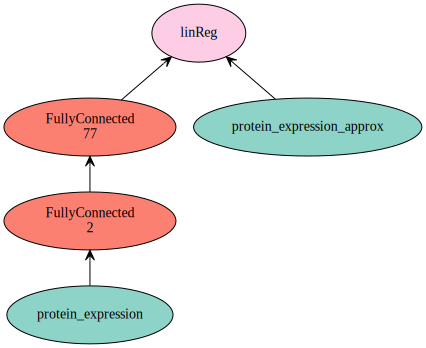

In [8]:
model = mx.mod.Module(
    symbol = linReg ,
    data_names=['protein_expression'],
    label_names = ['protein_expression_approx']
)
mx.viz.plot_network(symbol=linReg, node_attrs={"shape":"oval","fixedsize":"false"})

# Train the Neural Network

In [9]:
batch_size = 50
num_epoch = 100
rseed = 123

In [10]:
!rm data/models/pca_nn*

rm: cannot remove 'data/models/pca_nn*': No such file or directory


In [11]:
np.random.seed(rseed)
mx.random.seed(rseed)

model.bind(
    data_shapes=[('protein_expression', (batch_size,full_data_matrix.shape[1]))], 
    label_shapes=[('protein_expression_approx', (batch_size,full_data_matrix.shape[1]))]
)

model.fit(
    mx.io.NDArrayIter(
        full_data_matrix,
        full_data_matrix,
        batch_size=batch_size, 
        shuffle=True
    ),
    optimizer_params={
        'learning_rate':0.5, 
        'momentum': 0.9
    },
    num_epoch=num_epoch,
    eval_metric='mse',
    epoch_end_callback  = mx.callback.do_checkpoint(
        "data/models/pca_nn", 
        int(max(1,num_epoch/100))
    )
)

INFO:root:Epoch[0] Train-mse=0.231608
INFO:root:Epoch[0] Time cost=0.010
INFO:root:Saved checkpoint to "data/models/pca_nn-0001.params"
INFO:root:Epoch[1] Train-mse=0.040323
INFO:root:Epoch[1] Time cost=0.010
INFO:root:Saved checkpoint to "data/models/pca_nn-0002.params"
INFO:root:Epoch[2] Train-mse=0.027482
INFO:root:Epoch[2] Time cost=0.010
INFO:root:Saved checkpoint to "data/models/pca_nn-0003.params"
INFO:root:Epoch[3] Train-mse=0.026833
INFO:root:Epoch[3] Time cost=0.013
INFO:root:Saved checkpoint to "data/models/pca_nn-0004.params"
INFO:root:Epoch[4] Train-mse=0.026255
INFO:root:Epoch[4] Time cost=0.010
INFO:root:Saved checkpoint to "data/models/pca_nn-0005.params"
INFO:root:Epoch[5] Train-mse=0.025845
INFO:root:Epoch[5] Time cost=0.016
INFO:root:Saved checkpoint to "data/models/pca_nn-0006.params"
INFO:root:Epoch[6] Train-mse=0.025332
INFO:root:Epoch[6] Time cost=0.010
INFO:root:Saved checkpoint to "data/models/pca_nn-0007.params"
INFO:root:Epoch[7] Train-mse=0.024767
INFO:root:

In [12]:
pcorr = model.score(
    mx.io.NDArrayIter(
        full_data_matrix,
        full_data_matrix,
        batch_size=batch_size, 
        shuffle=False
    ), 
    mx.metric.PearsonCorrelation()
)
print("Achieved {0:.3f} validation PearsonCorrelation".format(pcorr[0][1]))

Achieved 0.600 validation PearsonCorrelation


# Extract the "PCA" layer's activations (outputs)

In [13]:
pca_extract = PCAin.eval(
    ctx=mx.cpu(),
    protein_expression=mx.nd.array(full_data_matrix),
    **model.get_params()[0]
)[0].asnumpy()

In [14]:
dat['PC1'] = pd.Series(pca_extract[:,0], index=dat.index)
dat['PC2'] = pd.Series(pca_extract[:,1], index=dat.index)

In [15]:
colormap = {
    'failed':'red',
    'none':'green',
    'normal':'blue',
    'rescued':'purple'
}

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVu

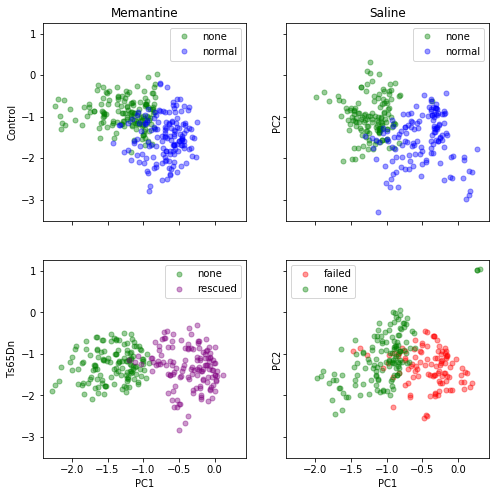

In [16]:
plti = -1
fig,axes = plt.subplots(2,2,True,True,figsize=(8,8))
for genotype, genotypeGroup in dat.groupby('Genotype'):
    for trt, treatmentGroup in genotypeGroup.groupby('Treatment'):
        plti += 1
        ax = axes.flatten()[plti]
        for name, group in treatmentGroup.groupby('LearningType'):
            ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name,alpha=.4, color=colormap[name])
        ax.legend()
        if plti<=1:
            ax.set_title(trt)
        else:
            ax.set_xlabel('PC1')
        if plti==0 or plti==2:
            ax.set_ylabel(genotype)
        if plti==1 or plti==3:
            ax.set_ylabel('PC2')


# Create learning animations

In [17]:
import os

#### Load training epoch snapshots as history:

In [18]:
pca_history = []
predict_history = []
for fname in sorted(os.listdir('data/models')):
    if fname.endswith('params') and fname.startswith('pca_nn'):
        epoch = int(fname.split('-',1)[1].rsplit('.',1)[0])
        chkpt = mx.model.load_checkpoint('data/models/pca_nn',epoch)
        pca_history.append(PCAin.eval(ctx=mx.cpu(),protein_expression=mx.nd.array(full_data_matrix),**chkpt[1])[0].asnumpy())
        predict_history.append(PCAout.eval(ctx=mx.cpu(),protein_expression=mx.nd.array(full_data_matrix),**chkpt[1])[0].asnumpy())
pca_history = np.array(pca_history)
predict_history = np.array(predict_history)
pca_history.shape,predict_history.shape

((100, 1080, 2), (100, 1080, 77))

#### Plot the "PCA" layer's activations for each snapshot and combine the images into an animated GIF:

In [19]:
!mkdir -p data/pca_history
!rm data/pca_history/*

rm: cannot remove 'data/pca_history/*': No such file or directory


In [20]:
plt.ioff()

for pci,pch in enumerate(pca_history):
    dat['PC1'] = pd.Series(pch[:,0], index=dat.index)
    dat['PC2'] = pd.Series(pch[:,1], index=dat.index)

    fig,axes = plt.subplots(2,2,True,True,figsize=(8,8))
    plti = -1
    for genotype, genotypeGroup in dat.groupby('Genotype'):
        for trt, treatmentGroup in genotypeGroup.groupby('Treatment'):
            plti += 1
            ax = axes.flatten()[plti]
            ax.set_xlim(pca_history.min((0,1))[0],pca_history.max((0,1))[0])
            ax.set_ylim(pca_history.min((0,1))[1],pca_history.max((0,1))[1])
            
            for name, group in treatmentGroup.groupby('LearningType'):
                ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name,alpha=.4, color=colormap[name])
            ax.legend()
            if plti<=2:
                ax.set_title(trt)
            else:
                ax.set_xlabel('PC1')
            if plti==1 or plti==3:
                ax.set_ylabel('PC2')
            if plti==2 or plti==4:
                ax.set_ylabel(genotype)
    fig.savefig('data/pca_history/step_%04d.png'%pci)
    plt.close(fig)
plt.ion()

In [21]:
!convert -delay 10 -loop 0 data/pca_history/*.png data/pca_history/pca_history.gif

/bin/sh: 1: convert: not found


![pca_history.gif](data/pca_history/pca_history.gif)

Text(0, 0.5, 'PC2')

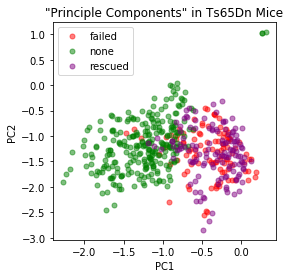

In [22]:
plotDat = dat.loc[dat.Genotype=='Ts65Dn']#.loc[dat.LearningType!='none']

fig, ax = plt.subplots(figsize=(4,4))
ax.margins(0.05)
for name, group in plotDat.groupby('LearningType'):
    ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name, color=colormap[name], alpha=.5)
ax.legend()

ax.set_title('"Principle Components" in Ts65Dn Mice')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#### Plot the neural network's outputs to show increasing correlation:

In [23]:
!mkdir -p data/pca_predict_history
!rm data/pca_predict_history/*

rm: cannot remove 'data/pca_predict_history/*': No such file or directory


In [24]:
plt.ioff()
for pci,pch in enumerate(predict_history):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.scatter(full_data_matrix.flatten(),pch.flatten(),alpha=.2)
    ax.set_title('Protein expression training')
    ax.set_xlabel('Observed (true) expression')
    ax.set_ylabel('Predicted expression')
    fig.savefig('data/pca_predict_history/step_%04d.png'%pci)
    plt.close(fig)
plt.ion()

In [25]:
!convert -delay 10 -loop 0 data/pca_predict_history/*.png data/pca_predict_history/pca_predict_history.gif

/bin/sh: 1: convert: not found


![pca_predict_history.gif](data/pca_predict_history/pca_predict_history.gif)